## ServeNet: Using LSTMs in Keras: 

Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate emoji. 

Run the following cell to load the Keras packages.

In [ ]:
!pip install plaidml-keras==0.3.0rc1 plaidml==0.3.0rc1

In [3]:
# import plaidml.keras
# plaidml.keras.install_backend()
import nltk
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import csv
import h5py
from pandas import HDFStore, read_hdf
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence



np.random.seed(0)
%matplotlib inline

/Applications/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## (Optional Read from CSV)

In [3]:
def read_csv(filename = 'data/service.csv'):
    phrase = []
    label = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            label.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(label)

    return X, Y

In [5]:
X, Y = read_csv('../data/service.csv')

print("Service Description: \n" + X[0])
print("Service Classification:" + Y[0])

type(X)

Service Description: 
It has been split into multiple APIs, including the Twitter Ads API, Twitter Search Tweets API, and Twitter Direct Message API. This profile is maintained for historical, research, and reference purposes only.The Twitter micro-blogging service includes two RESTful APIs. The Twitter REST API methods allow developers to access core Twitter data. This includes update timelines, status data, and user information. The Search API methods give developers methods to interact with Twitter Search and trends data. The API presently supports the following data formats: XML, JSON, and the RSS and Atom syndication formats, with some methods only accepting a subset of these formats.
Service Classification:Social


numpy.ndarray

## 1. Read from H5

In [4]:
AllData = read_hdf('../data/RandomSplittedByCatagories.h5', key='AllData')
TrainServices = read_hdf('../data/RandomSplittedByCatagories.h5', key='Train')
TestServices = read_hdf('../data/RandomSplittedByCatagories.h5', key='Test')
print(TrainServices.shape)
print(TestServices.shape)

(8123, 2)
(2061, 2)


In [5]:
X = AllData['Service Desciption']
Y = AllData['Service Classification']

Train_X = list(TrainServices['Service Desciption'])
Train_Y = list(TrainServices['Service Classification'])

Test_X = list(TestServices['Service Desciption'])
Test_Y = list(TestServices['Service Classification'])

In [6]:
Train_X[0]

'Versal is an open publishing platform designed to transform online learning from passive presentations into interactive online educational experiences, without requiring coding experience. Using the Versal platform, teachers and subject matter experts can share their knowledge using a creation canvas, gadget architecture, open APIs, and flexible embedding options. Versal provides a simple iframe/postMessage-based API for building interactive learning applications which are called gadgets. Developers use HTML5/JS/CSS to create gadgets which are then hosted on the platform and configured by teachers for learners to interact with. The set of services include persistence, asset uploading/transcoding, and assessment.'

## 2. Text to index by Glove (Option 1)

In [7]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [8]:
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
print("vocab size in corpus: " + str(vocab_size))

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../data/glove.6B.50d.txt')

print("vocab size in Glove:", len(word_to_index))

vocab size in corpus: 23560
vocab size in Glove: 400000


In [9]:
WordsNotInGlove = []

for k, v in t.word_index.items():
    if k not in word_to_index:
        WordsNotInGlove.append(k)
        
print("length:", len(WordsNotInGlove))

length: 8619


In [10]:
WordsNotInGlove

["user's",
 'intrinio',
 'jsonp',
 'sportradar',
 "it's",
 "api's",
 'webhooks',
 "users'",
 'cryptocurrency',
 'egnyte',
 'oauth2',
 "site's",
 'smpp',
 'blockchain',
 'litecoin',
 "company's",
 'polysync',
 'gnip',
 "don't",
 'mendix',
 "world's",
 "developer's",
 "service's",
 'webhook',
 'shephertz',
 'ckan',
 'roanuz',
 'trafiklab',
 'mapbox',
 'liveperson',
 'geocode',
 'webservice',
 "they're",
 "customer's",
 "provider's",
 'twilio',
 "platform's",
 'flipkart',
 'vantiv',
 'fantasydata',
 'acquia',
 'businessusa',
 'clickbank',
 'airmap',
 'messagebird',
 'ooyala',
 'xignite',
 'plivo',
 "google's",
 "customers'",
 'bugsnag',
 'app42',
 'virool',
 'mapmyindia',
 'atlasct',
 'skyscanner',
 'mashape',
 'agendize',
 "website's",
 'data8',
 "what's",
 'coinbase',
 "client's",
 'cryptocurrencies',
 'geojson',
 'payfort',
 'imagga',
 'ecwid',
 'addthis',
 "application's",
 'shopify',
 'thethings',
 'daac',
 'swrve',
 'rightscale',
 'magento',
 'sharethis',
 "uk's",
 'datastore',
 'gt

In [11]:
t.word_index["nasa's"]

3339

### use Glove5b to Index dataset

In [12]:
import json

In [13]:
words = text_to_word_sequence(Train_X[0])
print(words)    
double_quotations_words = json.dumps(words)
print(double_quotations_words) 

['versal', 'is', 'an', 'open', 'publishing', 'platform', 'designed', 'to', 'transform', 'online', 'learning', 'from', 'passive', 'presentations', 'into', 'interactive', 'online', 'educational', 'experiences', 'without', 'requiring', 'coding', 'experience', 'using', 'the', 'versal', 'platform', 'teachers', 'and', 'subject', 'matter', 'experts', 'can', 'share', 'their', 'knowledge', 'using', 'a', 'creation', 'canvas', 'gadget', 'architecture', 'open', 'apis', 'and', 'flexible', 'embedding', 'options', 'versal', 'provides', 'a', 'simple', 'iframe', 'postmessage', 'based', 'api', 'for', 'building', 'interactive', 'learning', 'applications', 'which', 'are', 'called', 'gadgets', 'developers', 'use', 'html5', 'js', 'css', 'to', 'create', 'gadgets', 'which', 'are', 'then', 'hosted', 'on', 'the', 'platform', 'and', 'configured', 'by', 'teachers', 'for', 'learners', 'to', 'interact', 'with', 'the', 'set', 'of', 'services', 'include', 'persistence', 'asset', 'uploading', 'transcoding', 'and', 'as

In [14]:
def glove_word_to_index(X):

    allservices = []

    for s in X:

        #Keras text to words (tokenizer)
        words = text_to_word_sequence(s)

        #double_quotations_words = json.dumps(words)

        service = []

        for w in words:

            if w in word_to_index:
                index = word_to_index[w]
                service.append(index)

        allservices.append(service)

    return allservices

In [15]:
indexed_Train_X = glove_word_to_index(Train_X)
indexed_Test_X = glove_word_to_index(Test_X)

In [16]:
print(indexed_Train_X[4])
print(Train_X[4])
print(indexed_Test_X[4])
print(Test_X[4])

[192973, 43010, 350362, 151349, 111453, 54718, 113825, 104991, 268046, 189825, 54718, 61722, 148107, 193716, 188838, 155226, 151349, 291186, 322777, 85125, 125126, 54718, 264636, 268046, 343876, 189825, 192973, 121851, 151349, 306010, 191604, 189825, 301000, 357109, 178623, 344939, 117493, 52520, 294049, 54273, 143043, 57459, 54718, 384515, 57836, 122455, 152908, 357266, 196150, 57459, 136753, 374205, 360915, 86363, 57840, 357212, 188929, 155226, 357266, 306616, 57459, 374253, 392023, 273428, 182915, 220930, 350396, 313432, 269798, 272583, 325746, 270970, 102738, 57840, 45107, 267087, 188481, 357266, 267063, 343872]
ONEIS is a system for creating and curating collections of information and associated files. It includes functions for precise searching, browsing, discovery, and notification of stored information. ONEIS is designed for representing interrelated information rather than highly structured data. ONEIS also provides an extensive API and web application development framework. T

## 2. Text to Index by Tokenizer (Option 2)

In [247]:
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
print("vocab size: " + str(vocab_size))

word_to_index = t.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

encoded_X = t.texts_to_sequences(X)

vocab size: 23560


In [47]:
print(encoded_X[1])

[2, 2467, 4, 13, 34, 72, 3, 97, 305, 30, 2, 2467, 505, 241, 17, 56, 5, 215, 7, 15094, 305, 1, 276, 3723, 617, 402, 6672, 2545, 1, 43, 2, 4, 13, 51, 34, 72, 3, 325, 305, 1, 117, 2, 2467, 4, 142, 290, 539, 78, 42, 105, 44, 847, 52, 13, 34, 75, 9, 44, 44, 847, 33, 1, 466, 86, 6, 974, 8, 3552, 4, 3553, 789]


In [57]:
indexed_Train_X = t.texts_to_sequences(Train_X) 
indexed_Test_X = t.texts_to_sequences(Test_X) 

## index_to_word

In [116]:
word_to_index['apple']

57797

## 2. Text to Index by NTLK (Option 3)

In [117]:
import nltk, re, pprint
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords

In [102]:
text = list(X)
alltext = ''.join(text)

In [106]:
tokens = word_tokenize(alltext)
len(tokens)

713679

In [140]:
clean_tokens = []
stop_words = []

sr = stopwords.words('english')
for token in tokens:
    if token not in sr:
        clean_tokens.append(token)
    else:
        stop_words.append(token)

In [143]:
print(len(stop_words))

199904


In [149]:
stop_words[4]

'and'

In [141]:
freq = FreqDist(clean_tokens)

In [165]:
freq.most_common()

[(',', 37352),
 ('.', 28662),
 ('API', 16772),
 ('The', 9176),
 ('data', 5621),
 ('allows', 5304),
 ('users', 4454),
 ('developers', 4259),
 ('access', 4122),
 ('provides', 4087),
 ('service', 3971),
 ('applications', 3948),
 ('information', 3251),
 (')', 2271),
 ('(', 2262),
 ('integrate', 2261),
 ('services', 2254),
 ("'s", 2221),
 ('It', 2090),
 ('available', 2044),
 ('JSON', 1901),
 ('platform', 1845),
 ('REST', 1682),
 ('uses', 1680),
 ('web', 1646),
 ('create', 1598),
 ('methods', 1588),
 ('include', 1575),
 ('also', 1550),
 ('offers', 1524),
 ('online', 1524),
 ('functionality', 1493),
 ('calls', 1472),
 ('RESTful', 1416),
 ('user', 1365),
 ('use', 1359),
 ('mobile', 1331),
 ('This', 1326),
 ('responses', 1303),
 ('using', 1287),
 ('XML', 1281),
 ('account', 1203),
 ('search', 1187),
 ('SMS', 1148),
 ('management', 1147),
 ('application', 1122),
 ('via', 1102),
 ('used', 1086),
 ('content', 1041),
 ('returns', 1007),
 ('based', 1005),
 ('including', 995),
 ('formatted', 950),
 (

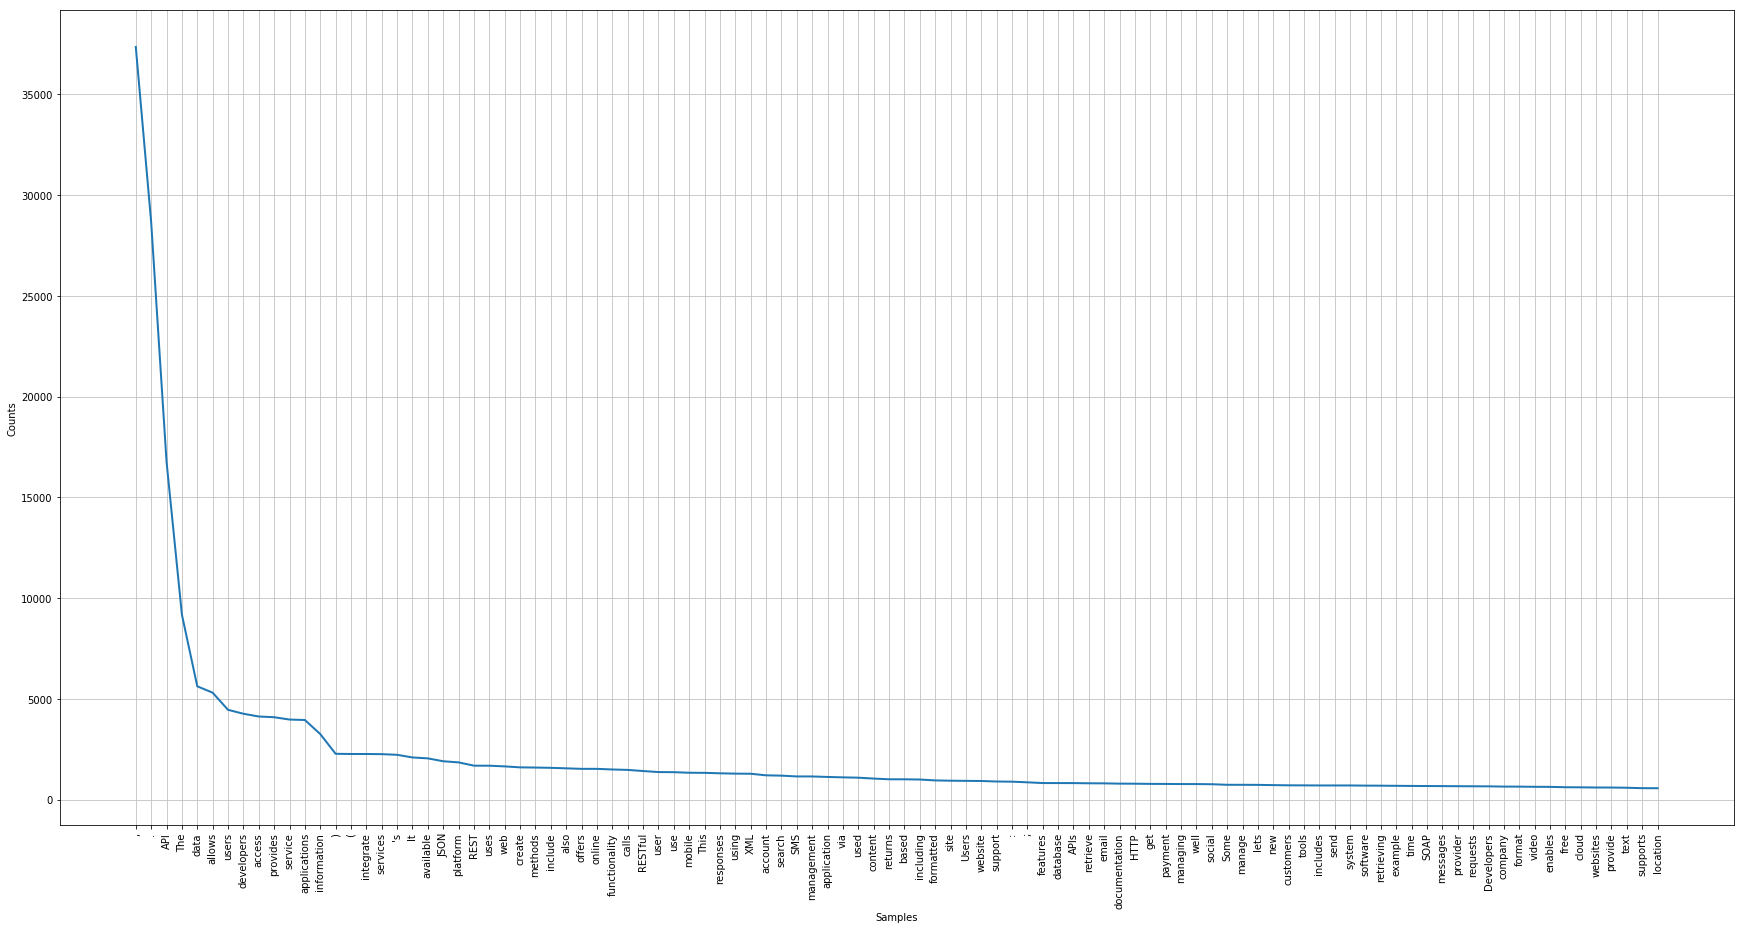

In [142]:
plt.figure(figsize=(30, 15))
freq.plot(100, cumulative=False)
plt.savefig('freq.pdf', format='pdf', dpi=300)

In [130]:
from nltk.corpus import wordnet

In [163]:
syn = wordnet.synsets("mapbox")
print(syn[0].definition())
print(syn[0].examples())

IndexError: list index out of range

In [134]:
from nltk.corpus import wordnet

synonyms = []
for syn in wordnet.synsets('service'):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())
print(synonyms)

['service', 'service', 'service', 'religious_service', 'divine_service', 'service', 'service', 'military_service', 'armed_service', 'service', 'Service', 'Robert_William_Service', 'avail', 'help', 'service', 'service', 'table_service', 'servicing', 'service', 'service', 'serve', 'service', 'service', 'serving', 'service_of_process', 'overhaul', 'inspection_and_repair', 'service', 'service', 'service', 'serve', 'service', 'serve', 'service']


In [139]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
print(stemmer.stem("working's"))
print(stemmer.stem('worked'))

working'
work


In [150]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('playing', pos="v"))
print(lemmatizer.lemmatize('playing', pos="n"))
print(lemmatizer.lemmatize('playing', pos="a"))
print(lemmatizer.lemmatize('playing', pos="r"))

play
playing
playing
playing


In [164]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
print(stemmer.stem('stones'))
print(stemmer.stem('speaking'))
print(stemmer.stem('bedroom'))
print(stemmer.stem('jokes'))
print(stemmer.stem('lisa'))
print(stemmer.stem("It's"))
print('----------------------')
print(lemmatizer.lemmatize('stones'))
print(lemmatizer.lemmatize('speaking'))
print(lemmatizer.lemmatize('bedroom'))
print(lemmatizer.lemmatize('jokes'))
print(lemmatizer.lemmatize('lisa'))
print(lemmatizer.lemmatize("google's"))

stone
speak
bedroom
joke
lisa
it'
----------------------
stone
speaking
bedroom
joke
lisa
google's


## 3. Padding to same length

In [17]:
maxLen = 110
padded_X = pad_sequences(encoded_X, maxlen=maxLen, padding='post')
padded_X.shape

NameError: name 'encoded_X' is not defined

In [18]:
indexed_padded_Train_X = pad_sequences(indexed_Train_X, maxlen=maxLen, padding='post')
indexed_padded_Test_X = pad_sequences(indexed_Test_X, maxlen=maxLen, padding='post')

## 4. Category to one-hot

In [19]:
categories = list(set(Y))
categories_num = len(categories)
index = list(range(len(categories)))
index_to_category = dict(zip(index, categories)) 
category_to_index = dict(zip(categories, index))

In [29]:
Y

1                    Social
3                    Photos
5                 eCommerce
7                     Music
10                  Mapping
13                   Social
17              Advertising
18                Reference
22                   Search
24                   Photos
28                    Music
29                Analytics
32                  Mapping
34                   Events
38                eCommerce
39                  Mapping
40                 Payments
41                    Music
42               Enterprise
44                   Search
45                   Photos
47                  Mapping
48                   Search
49                   Search
50                    Music
51                eCommerce
52                   Social
53                  Mapping
56                   Photos
57                    Media
                ...        
15306              Shipping
15307                Photos
15308               Medical
15310             Financial
15311            Ent

In [20]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [21]:
Y_Index = np.asarray([category_to_index[k] for k in Y])
Y_one_hot = convert_to_one_hot(Y_Index, 50)
Y_one_hot.shape

(10184, 50)

In [22]:
Train_Y_Index = np.asarray([category_to_index[k] for k in Train_Y])
Train_Y_one_hot = convert_to_one_hot(Train_Y_Index, 50)
print(Train_Y_one_hot.shape)

Test_Y_Index = np.asarray([category_to_index[k] for k in Test_Y])
Test_Y_one_hot = convert_to_one_hot(Test_Y_Index, 50)
print(Test_Y_one_hot.shape)

(8123, 50)
(2061, 50)


## 4. Save Datasets (np to h5)

In [28]:
h5f = h5py.File('../data/SplittedPaddedIndexedServiceDataset.h5', 'w')
h5f.create_dataset('indexed_padded_Train_X', data=indexed_padded_Train_X)
h5f.create_dataset('Train_Y_one_hot', data=Train_Y_one_hot)   
h5f.create_dataset('indexed_padded_Test_X', data=indexed_padded_Test_X)
h5f.create_dataset('Test_Y_one_hot', data=Test_Y_one_hot)
h5f.close()

OSError: Unable to create file (Unable to truncate a file which is already open)

In [265]:
h5f = h5py.File('../data/SplittedPaddedIndexedServiceDataset.h5','r')
indexed_padded_Train_X = h5f['indexed_padded_Train_X'][:]
Train_Y_one_hot = h5f['Train_Y_one_hot'][:]
indexed_padded_Test_X = h5f['indexed_padded_Test_X'][:]
Test_Y_one_hot = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8145, 110) (8145, 50)
(2037, 110) (2037, 50)
